<a href="https://colab.research.google.com/github/syamkakarla98/Satellite_Imagery_Analysis/blob/main/Classification/Land_Cover_Classification_in_Satellite_Imagery_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сегментація зображень за допомогою K-NNC, SVM, LightGBM, Naive Bayes

Для правильної роботи даної програми необхідно встановити пакет <span style="color: red">gdal</span>

In [ ]:
!pip install earthpy gdal

## 1. Імпортування всіх необхідних модулів

In [ ]:
!pip install scikit-learn-intelex

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%cd /tmp/shared


/tmp/shared


## 2. Зчитування данних та формування датасету

Для датасету було вирішено використати [Sentinel hub](https://www.sentinel-hub.com/) в якому було скачано знімок річки Дніпро та берегової зони.

In [2]:
from glob import glob
S_sentinel_bands = glob("/tmp/shared/dataset4/6/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/dataset4/6/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B12_(Raw).tiff',

In [3]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))


In [4]:
arr_st = np.stack(l)

In [5]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 638
Width: 1094
Bands: 12


## 3. Візуалізація знімку для кожного діапазону

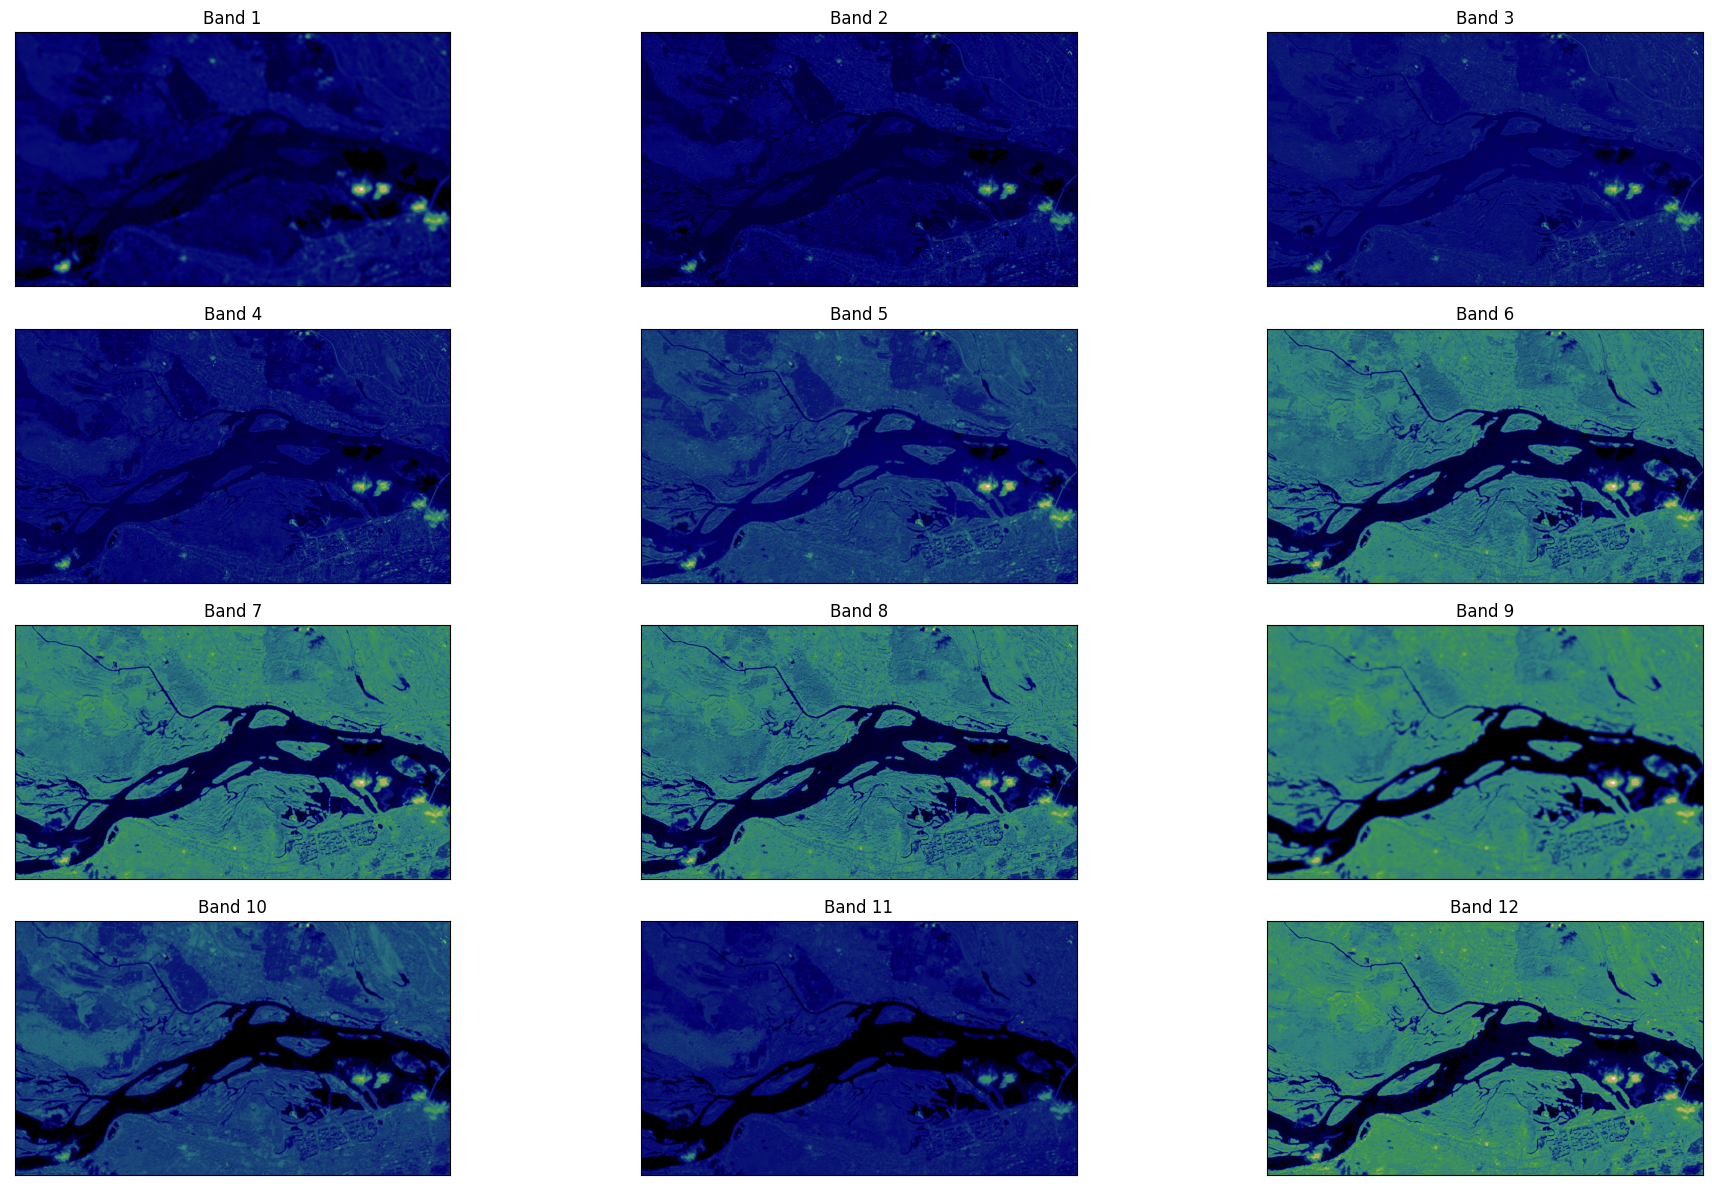

In [6]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 3, cbar = False)
plt.show()

### 3.1. Показ композитного зображення шляхом використання 3 2 і 1 каналів

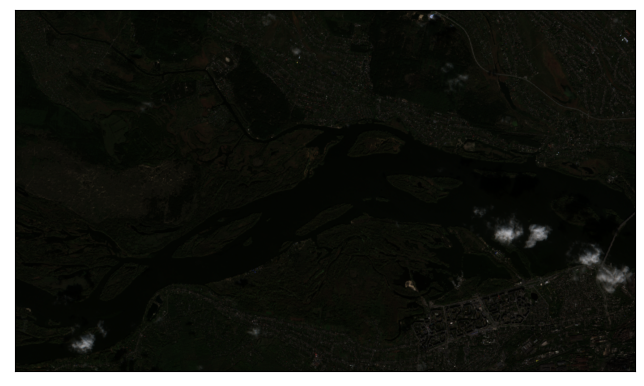

In [7]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  # title='RGB Composite Image'
                  )

plt.show()

Дане зображення можна покращити відрегулювавши деякі параметри

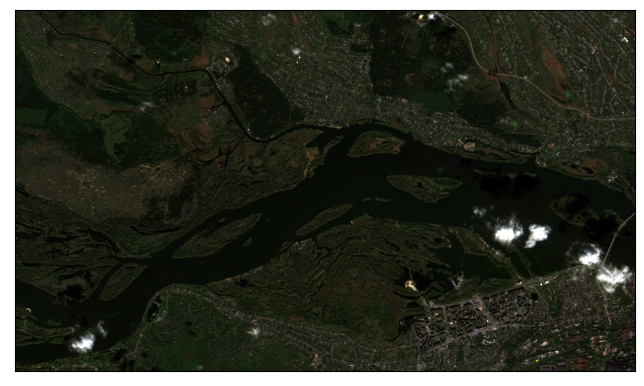

In [8]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

### 3.2. Діаграма розподілу кольорів в кожному з каналів

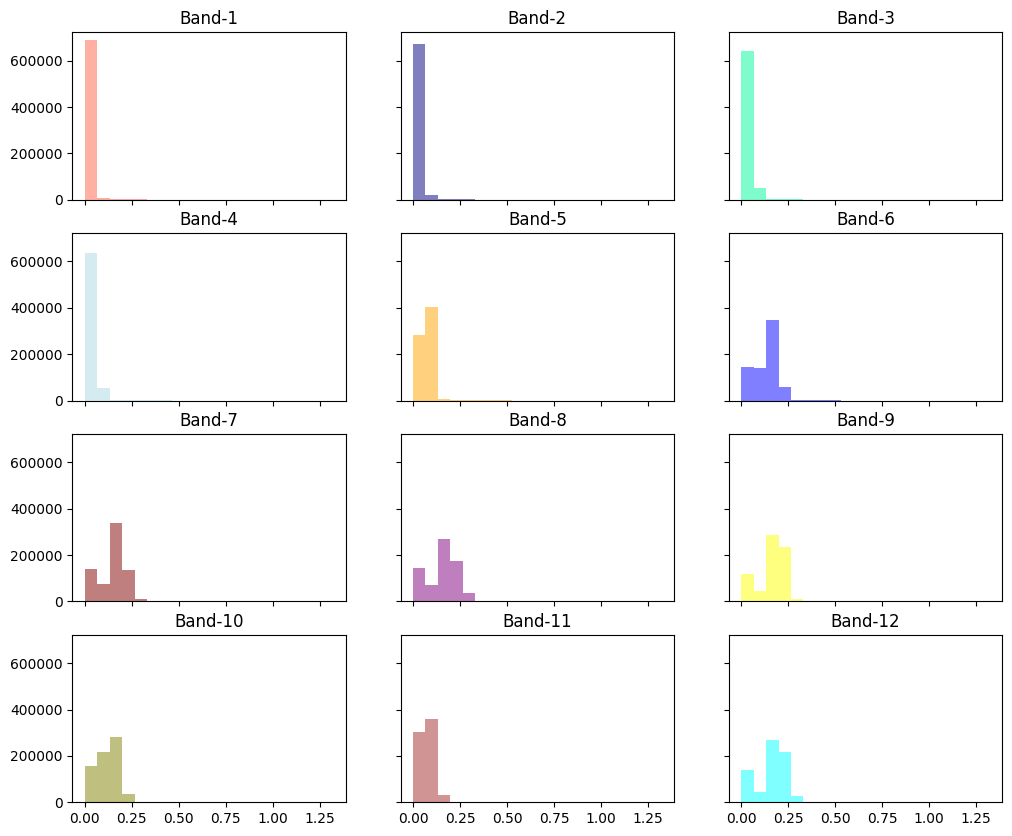

In [9]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', 'gray']

ep.hist(arr_st,
        colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)],
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

## 4. Підготовка та обробка данних

In [10]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(638, 1094, 12)

In [11]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(697972, 12)

Для створення матриці <b>Y</b> можна використати наявний класифікатор від Sentinel, який необхідно об'єднати з триканального зображення в звичайний двовимірний масив шляхом використання цілочисельного претсавлення значення кольору з використанням побітового зсуву. Далі ці значення кольорів трансофрмуються в ціле число від 1 до N, щоб задовільнити умову класифікатора. Також необхідно створити тип даних <b>dictionary</b> для кешування відповідних значень для кожного кольору та унеможливлення призначення іншого ідентифікатора для одного і того ж кольору в зображенні

In [12]:
color_dict = {}

In [13]:
def getFileArrayForY(path):
    l = []
    with rio.open(path,'r') as f:
        r = f.read(1)
        g = f.read(2)
        b =  f.read(3)
        rgb_arr = [r, g ,b]
        l.append(rgb_arr)
    #s = np.asarray(l * 255).astype(int)      # l.append(rgb)
    return l

In [14]:
def merge_channels(array):
    print(array.shape)
    merged = []
    r = (array[0] * 255).astype(int)
    g = (array[1] * 255).astype(int)
    b = (array[2] * 255).astype(int)
    rgb  = r
    rgb = np.left_shift(rgb, 8) + g
    rgb = np.left_shift(rgb, 8) + b
    merged.append(rgb)
    return np.asarray(merged)

In [15]:
def to_classes(array):
    unique_vals = np.unique(array)
    for idx, i in enumerate(unique_vals):
        if i in color_dict:
            array [ array == i] = color_dict[i]
        else:
            color_dict[i] = idx
            array [ array == i] = color_dict[i]



In [16]:
def get_y_data(path):
    #print(path)
    classifier_image = glob(f'{path}/*classification*.tiff')
    #print(classifier_image)
    image_path = classifier_image[0]
    #print(image_path)
    image_array3 = getFileArrayForY(image_path)
    image_array3np = np.asarray(image_array3[0])
    print(image_array3np.shape)
    image_array_merged = merge_channels(image_array3np)
    image_array_merged_np = np.asarray(image_array_merged)
    to_classes(image_array_merged_np)
    return image_array_merged_np


In [17]:
y_data = get_y_data("/tmp/shared/dataset4/6")

(3, 638, 1094)
(3, 638, 1094)


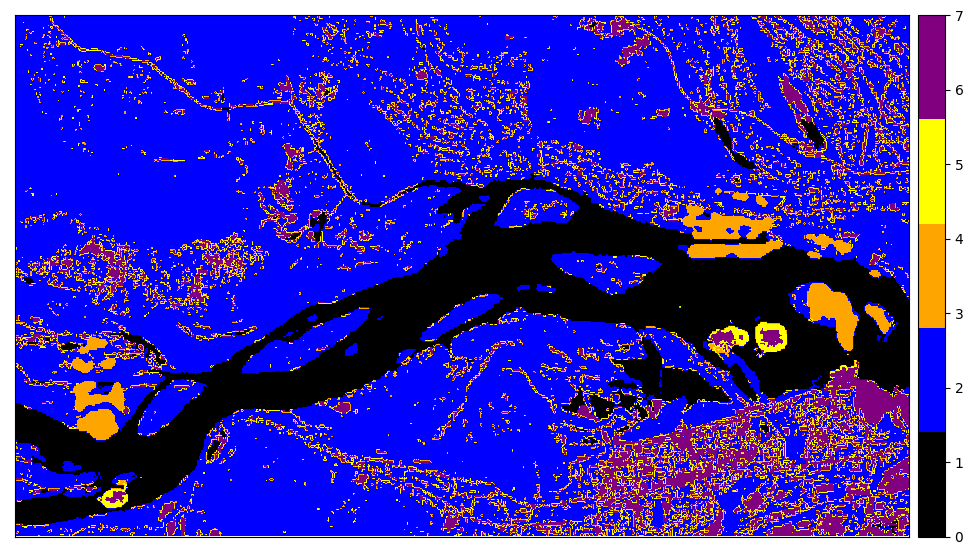

In [18]:
# Visualize Groundtruth

ep.plot_bands(y_data, cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([5.00000e+00, 1.25159e+05, 4.67893e+05, 0.00000e+00, 1.31900e+04,
        2.40000e+02, 0.00000e+00, 2.09700e+03, 8.78190e+04, 1.56900e+03]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

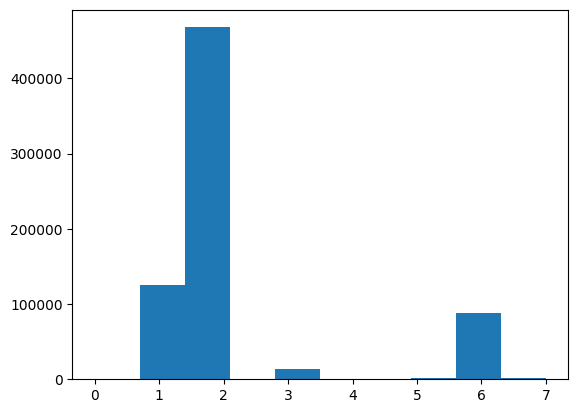

In [19]:
plt.hist(y_data.ravel())

# Train Test Split

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (488580, 12)
X_test Shape: (209392, 12)
y_train Shape: (488580,)
y_test Shape:(209392,)


# K-Nearest Neighbor Classifier (K-NNC)



In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [31]:
import pickle

knnModelFile = "/tmp/shared/knnc_ne2.sav"

pickle.dump(knn, open(knnModelFile, 'wb'))

In [32]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 93.02217849774586


In [94]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      0.96      0.95     37548
           2       0.95      0.98      0.96    140368
           3       0.72      0.36      0.48      3957
           4       0.65      0.15      0.25        72
           5       0.70      0.51      0.59       629
           6       0.83      0.73      0.78     26346
           7       0.83      0.90      0.86       471

    accuracy                           0.93    209392
   macro avg       0.70      0.58      0.61    209392
weighted avg       0.93      0.93      0.93    209392



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


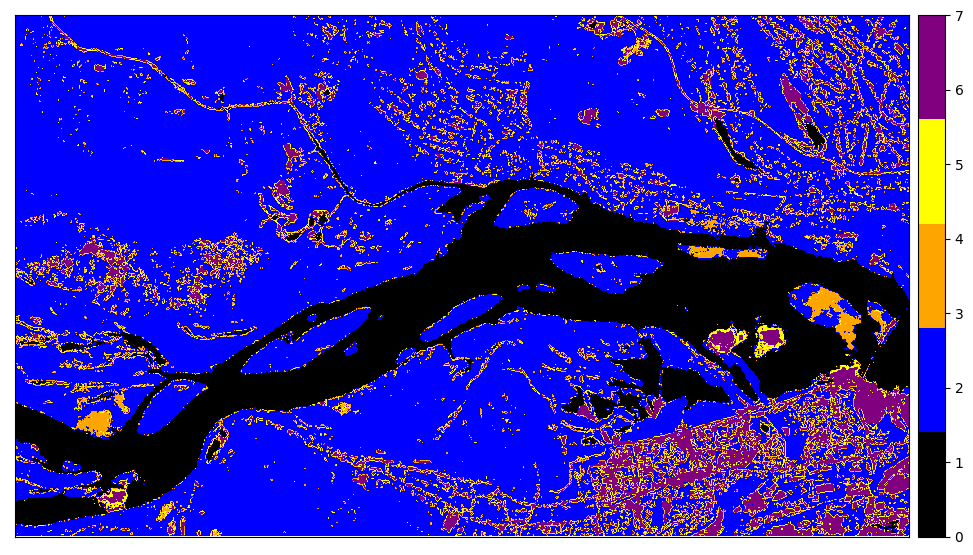

In [101]:
# Visualize Classification Map of K-NNC
knn_image_default = knn.predict(X_scaled).reshape((638,1094))
ep.plot_bands(knn_image_default, vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([1.28146e+05, 4.81311e+05, 0.00000e+00, 6.76600e+03, 0.00000e+00,
        5.30000e+01, 1.54200e+03, 0.00000e+00, 7.84920e+04, 1.66200e+03]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

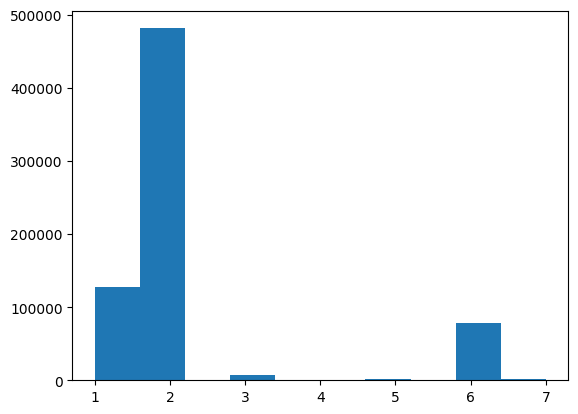

In [97]:
plt.hist(knn_image_default.reshape(-1))

In [26]:
knn_proba = knn.predict_proba(X_scaled)

In [27]:
knn_proba

array([[0.3, 0. , 0.7, 0. ],
       [0.2, 0. , 0.7, 0.1],
       [0.1, 0. , 0.8, 0.1],
       ...,
       [0. , 0. , 0.1, 0.9],
       [0. , 0. , 0.5, 0.5],
       [0.8, 0. , 0.1, 0.1]])

In [28]:
knn_proba1 = knn_proba[: , 0]
knn_proba2 = knn_proba[: , 1]
knn_proba3 = knn_proba[: , 2]
knn_proba4 = knn_proba[: , 3]

(array([220528.,  22849.,  24410.,      0.,   6929.,  10688.,   5386.,
             0.,   6259.,  62674.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

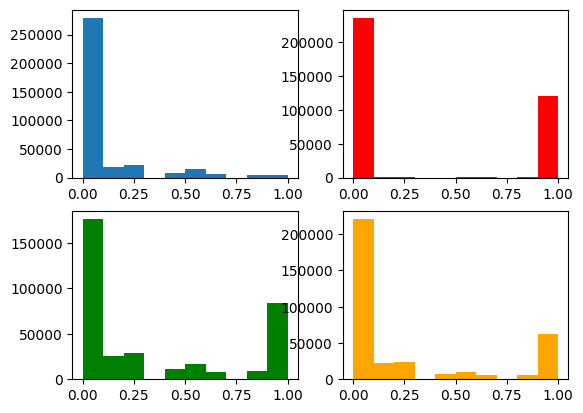

In [29]:
# ep.hist(np.array([knn_proba1, knn_proba2, knn_proba3, knn_proba4]))

# plt.show()
import matplotlib.pyplot as mplt
# mplt.hist(knn_proba4)
fig, axs = mplt.subplots(2, 2)
axs[0,0].hist(knn_proba1)
axs[0,1].hist(knn_proba2, color="red")
axs[1,0].hist(knn_proba3, color="green")
axs[1,1].hist(knn_proba4, color="orange")


# Support Vector Machine (SVM)

In [84]:
from sklearnex import patch_sklearn

patch_sklearn()

from sklearn.svm import SVC
svm = SVC(C=3.0, kernel='rbf', degree=6, cache_size=1024)
svm.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVC(C=3.0, cache_size=1024, degree=6)

In [103]:
svmModelFile = "/tmp/shared/svm_ne2.sav"

pickle.dump(svm, open(svmModelFile, 'wb'))

In [85]:
svm_pred = svm.predict(X_test)

(array([3.84120e+04, 1.44344e+05, 0.00000e+00, 1.22700e+03, 0.00000e+00,
        2.00000e+00, 4.74000e+02, 0.00000e+00, 2.44370e+04, 4.96000e+02]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

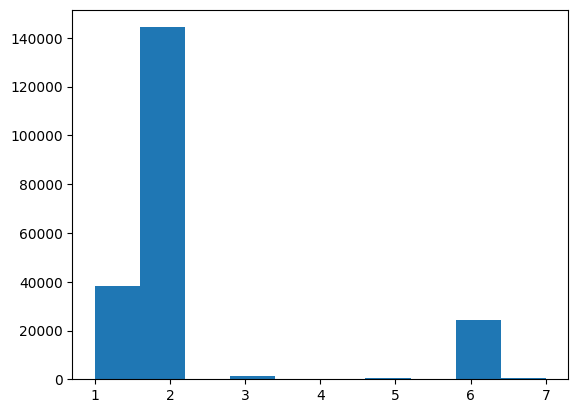

In [86]:
plt.hist(svm_pred)

In [87]:
print(f"Accuracy: {accuracy_score(y_test, svm_pred)*100}")

Accuracy: 93.31684114006265


In [48]:
#svm_proba = svm.predict_proba(X_scaled)

AttributeError: predict_proba is not available when  probability=False

In [88]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.94      0.96      0.95     37548
           2       0.95      0.98      0.97    140368
           3       0.76      0.24      0.36      3957
           4       1.00      0.03      0.05        72
           5       0.71      0.53      0.61       629
           6       0.82      0.76      0.79     26346
           7       0.87      0.91      0.89       471

    accuracy                           0.93    209392
   macro avg       0.76      0.55      0.58    209392
weighted avg       0.93      0.93      0.93    209392



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


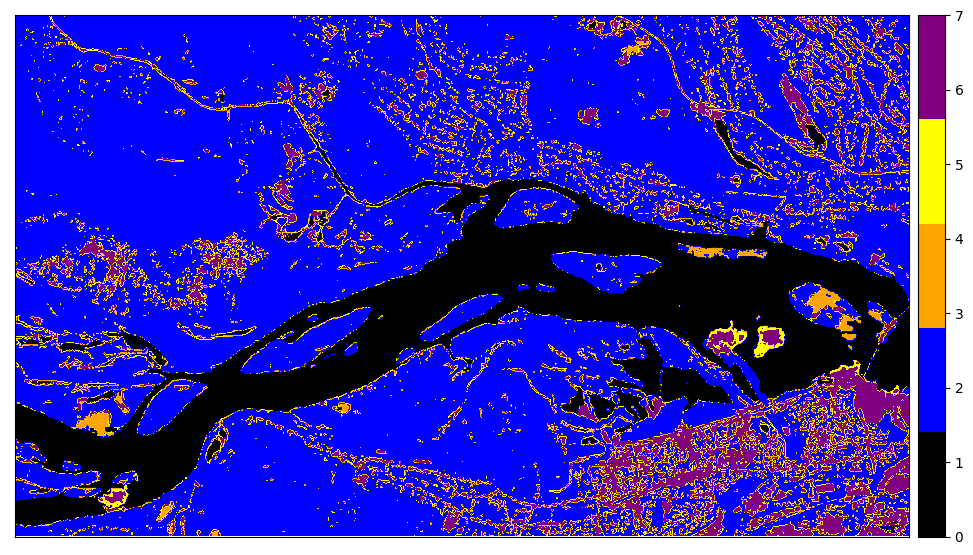

In [108]:
# Visualize Classification Map of SVM
svm_image = svm.predict(X_scaled).reshape((638,1094))
ep.plot_bands(svm_image, vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

# Light BGM

In [44]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py:235: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [112]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=y_train)

params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=15
params['num_class']=8 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 488580, number of used features: 12
[LightGBM] [Info] Start training from score -11.712964
[LightGBM] [Info] Start training from score -1.718597
[LightGBM] [Info] Start training from score -0.399939
[LightGBM] [Info] Start training from score -3.968719
[LightGBM] [Info] Start training from score -7.975295
[LightGBM] [Info] Start training from score -5.807602
[LightGBM] [Info] Start training from score -2.072905
[LightGBM] [Info] Start training from score -6.098013
[LightGBM] [Wa

In [113]:
gbmModelFile = "/tmp/shared/gbm_ne2.sav"

pickle.dump(clf, open(gbmModelFile, 'wb'))

In [114]:
lgb_predictions = clf.predict(X_test)

In [115]:
print(lgb_predictions[1], np.argmax(lgb_predictions[1]))

[8.60548996e-08 1.83874885e-03 9.95407878e-01 9.53125469e-04
 4.03024819e-06 3.35305219e-05 1.73902035e-03 2.35803910e-05] 2


In [116]:
# lbg_pred = [np.argmax(x) for x in lgb_predictions]
# np.array(lbg_pred).shape

lgb_pred = np.argmax(lgb_predictions, axis=1)
lgb_pred.shape

(209392,)

In [117]:
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")

Accuracy: 93.1659280201727


In [118]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      0.95      0.95     37548
           2       0.96      0.97      0.97    140368
           3       0.71      0.32      0.44      3957
           4       0.09      0.24      0.13        72
           5       0.62      0.55      0.58       629
           6       0.80      0.78      0.79     26346
           7       0.77      0.86      0.81       471

    accuracy                           0.93    209392
   macro avg       0.61      0.58      0.58    209392
weighted avg       0.93      0.93      0.93    209392



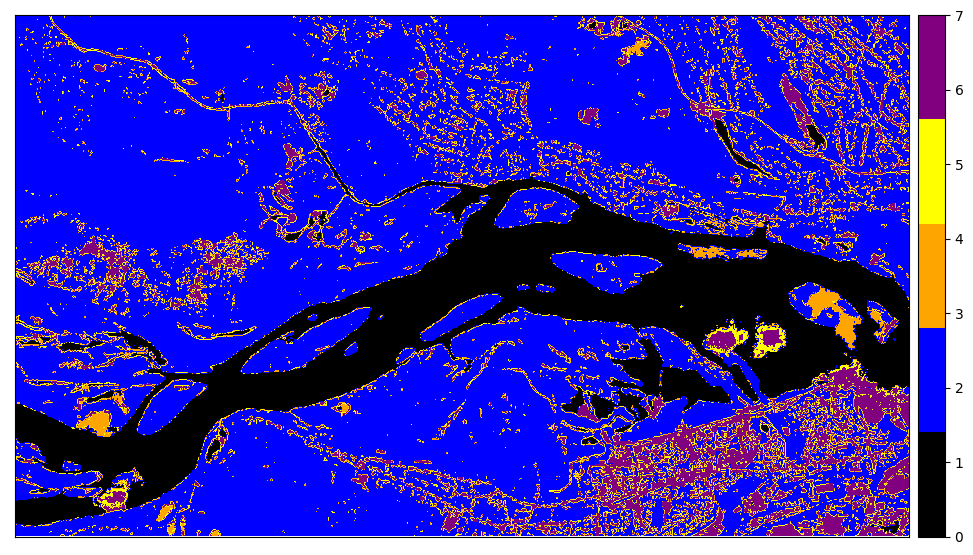

In [119]:
# Visualize Classification Map of LightGBM
gbm_image = np.argmax(clf.predict(X_scaled), axis=1).reshape((638,1094))
ep.plot_bands(gbm_image,vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([6.00000e+00, 1.26178e+05, 4.75873e+05, 0.00000e+00, 6.04900e+03,
        3.56000e+02, 0.00000e+00, 1.79400e+03, 8.59580e+04, 1.75800e+03]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

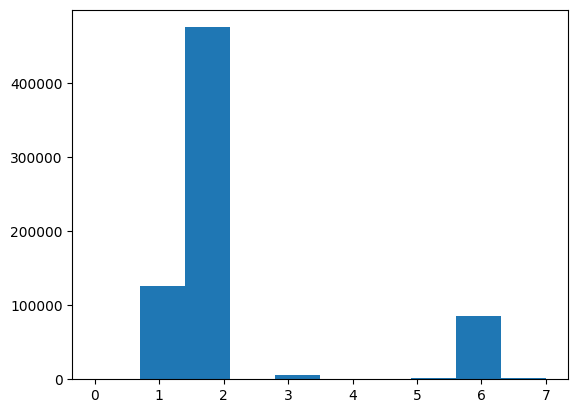

In [122]:
plt.hist(gbm_image.ravel())

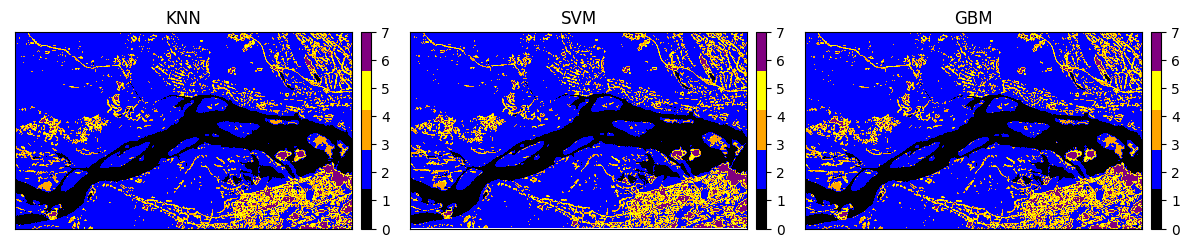

array([<AxesSubplot:title={'center':'KNN'}>,
       <AxesSubplot:title={'center':'SVM'}>,
       <AxesSubplot:title={'center':'GBM'}>], dtype=object)

## Naive bayess

In [96]:
from sklearn.naive_bayes import GaussianNB

In [97]:
gnb = GaussianNB()
gnb_res = gnb.fit(X_train, y_train)

In [98]:
gnb_pred = gnb.predict(X_test)

In [99]:
import pickle
gnbModelFile = "/tmp/shared/gnb.sav"

pickle.dump(gnb, open(gnbModelFile, 'wb'))

(array([1.00000e+00, 3.98090e+04, 1.36109e+05, 0.00000e+00, 1.53090e+04,
        1.31100e+03, 0.00000e+00, 8.43000e+02, 1.53510e+04, 6.59000e+02]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

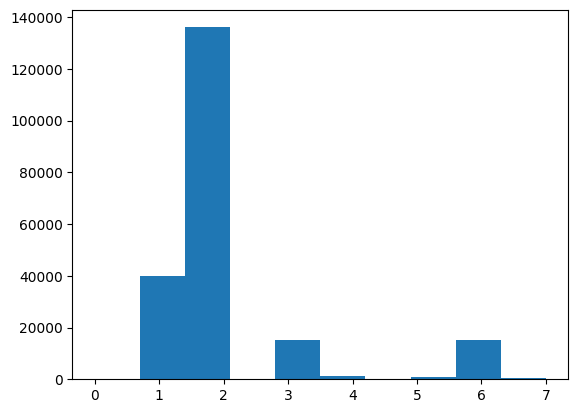

In [100]:
plt.hist(gnb_pred)

In [128]:
print(f"Accuracy: {accuracy_score(y_test, gnb_pred)*100}")

Accuracy: 83.39955681210361


In [129]:
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.89      0.94      0.92     37548
           2       0.93      0.90      0.91    140368
           3       0.06      0.24      0.10      3957
           4       0.01      0.25      0.02        72
           5       0.25      0.34      0.29       629
           6       0.73      0.43      0.54     26346
           7       0.67      0.93      0.78       471

    accuracy                           0.83    209392
   macro avg       0.57      0.63      0.57    209392
weighted avg       0.88      0.83      0.85    209392



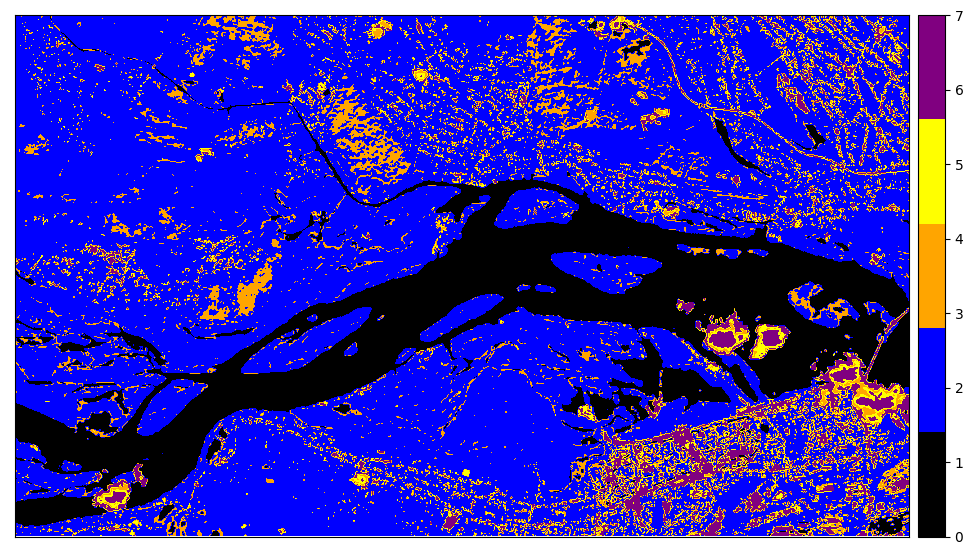

In [130]:
gnb_image = gnb.predict(X_scaled).reshape((638,1094))
ep.plot_bands(gnb_image,vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([5.00000e+00, 1.32830e+05, 4.54092e+05, 0.00000e+00, 5.02600e+04,
        4.71000e+03, 0.00000e+00, 2.82100e+03, 5.10410e+04, 2.21300e+03]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

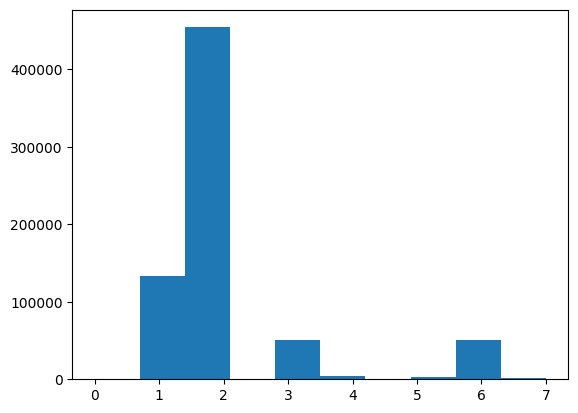

In [131]:
plt.hist(gnb_image.ravel())

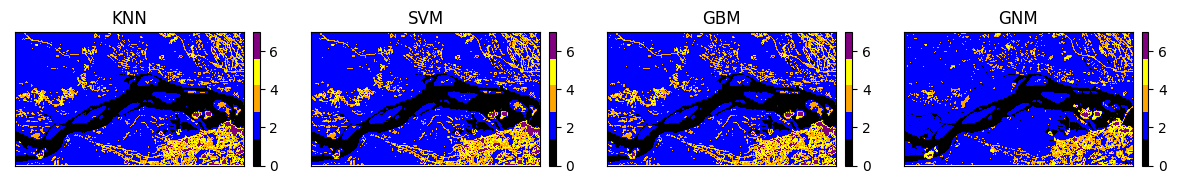

array([<AxesSubplot:title={'center':'KNN'}>,
       <AxesSubplot:title={'center':'SVM'}>,
       <AxesSubplot:title={'center':'GBM'}>,
       <AxesSubplot:title={'center':'GNM'}>], dtype=object)

In [136]:
ep.plot_bands(np.array([knn_image_default, svm_image, gbm_image, gnb_image]),
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']),
              cols=4, vmin=0,
              title=["KNN", "SVM", "GBM", "GNM"])

## Custom image


In [33]:
S_sentinel_bands = glob("/tmp/shared/test_images2/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/tmp/shared/test_images2/2022-08-24-00_00_2022-08-24-23_59_Sentinel-

In [34]:
l2 = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l2.append(f.read(1))


In [35]:
arr_st2 = np.stack(l2)

In [36]:
print(f'Height: {arr_st2.shape[1]}\nWidth: {arr_st2.shape[2]}\nBands: {arr_st2.shape[0]}')

Height: 733
Width: 1250
Bands: 12


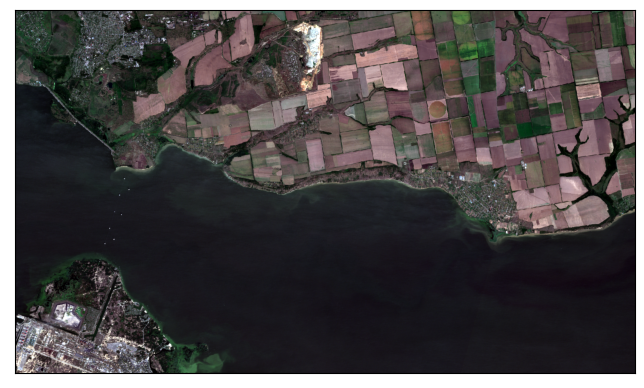

In [37]:
ep.plot_rgb(
    arr_st2,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [38]:
x2 = np.moveaxis(arr_st2, 0, -1)
x2.shape

(733, 1250, 12)

In [39]:
# from sklearn.preprocessing import StandardScaler

X_data2 = x2.reshape(-1, 12)

scaler2 = StandardScaler().fit(X_data2)

X_scaled2 = scaler2.transform(X_data2)

X_scaled2.shape

(916250, 12)

In [61]:
y_data2 = get_y_data("/tmp/shared/test_images2")
y_data2.shape

(3, 733, 1250)
(3, 733, 1250)


(1, 733, 1250)

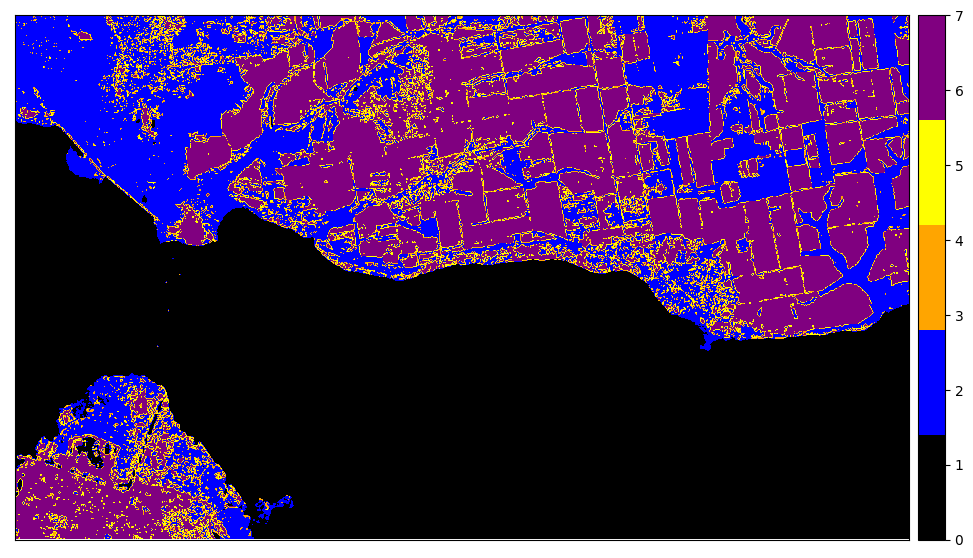

In [106]:
ep.plot_bands(y_data2,vmin=0, vmax=7, cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

(array([4.31762e+05, 0.00000e+00, 2.07941e+05, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.39700e+03, 0.00000e+00, 1.20000e+01, 2.75138e+05]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

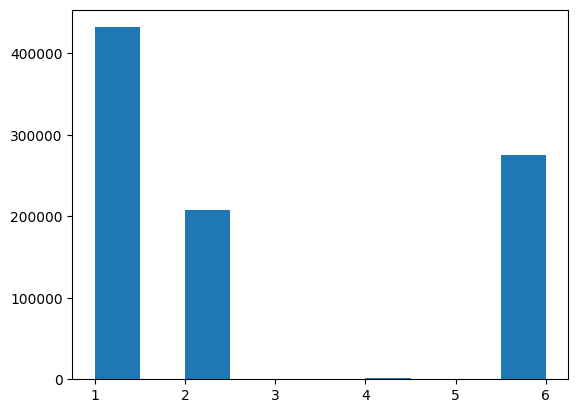

In [69]:
plt.hist(y_data2.ravel())

In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y_data2.ravel(), test_size=0.30, stratify = y_data2.ravel())

print(f'X_train Shape: {X_train2.shape}\nX_test Shape: {X_test2.shape}\ny_train Shape: {y_train2.shape}\ny_test Shape:{y_test2.shape}')

X_train Shape: (641375, 12)
X_test Shape: (274875, 12)
y_train Shape: (641375,)
y_test Shape:(274875,)


In [64]:
knn_pred2 = knn.predict(X_test2)

In [65]:
print(f"Accuracy: {accuracy_score(y_test2, knn_pred2)*100}")

Accuracy: 42.59863574351978


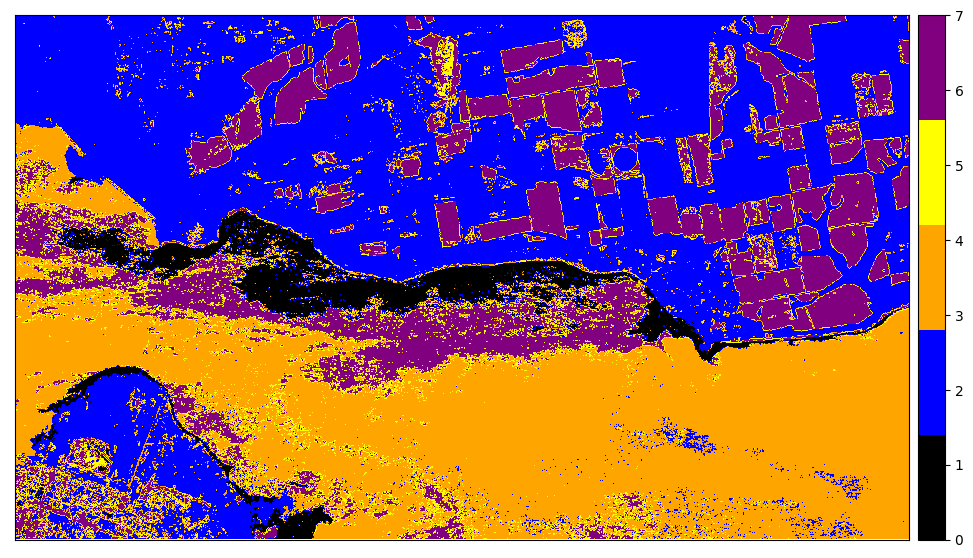

In [70]:
knn_image_default2 = knn.predict(X_scaled2).reshape((733, 1250))
ep.plot_bands(knn_image_default2, vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

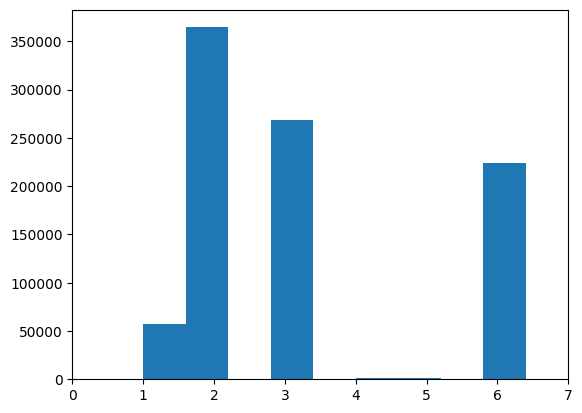

In [71]:
plt.hist(knn_image_default2.ravel())
plt.xlim(0, 7)
plt.show()

In [73]:
print(accuracy_score(y_data2.ravel(), knn_image_default2.ravel())*100)

42.526275579809


In [74]:
knn_class_report = classification_report(y_data2.ravel(), knn_image_default2.ravel())
print(knn_class_report)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.97      0.13      0.23    431762
           2       0.57      1.00      0.73    207941
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00      1397
           5       0.00      0.00      0.00        12
           6       0.56      0.46      0.51    275138
           7       0.00      0.00      0.00         0

    accuracy                           0.43    916250
   macro avg       0.30      0.23      0.21    916250
weighted avg       0.76      0.43      0.42    916250



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
knn_precisions = knn_class_report.split("\n")[2].split()[1]
knn_precisions

'0.57'

In [89]:
svm_pred2 = svm.predict(X_test2)

In [90]:
print(f"Accuracy: {accuracy_score(y_test2, svm_pred2)*100}")

Accuracy: 41.3962710322874


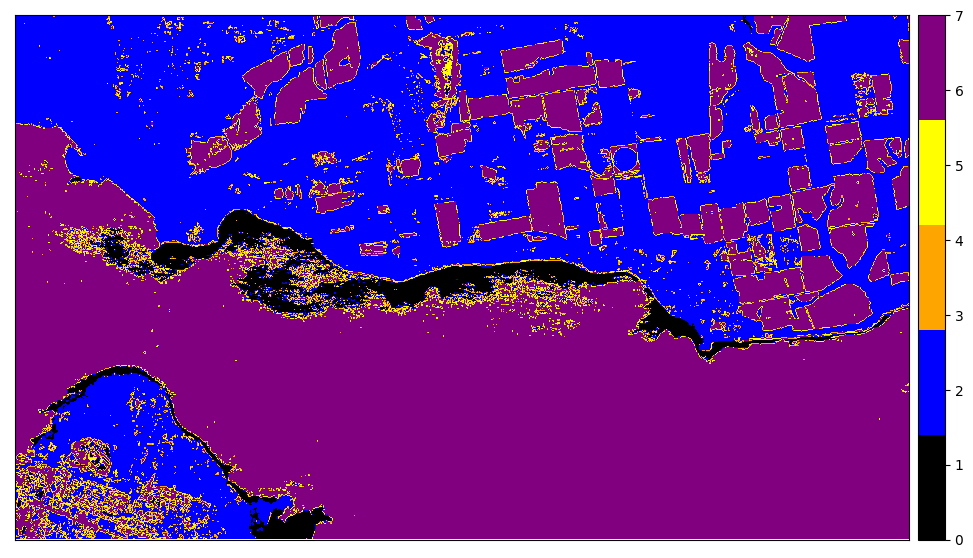

In [91]:
svm_image_default2 = svm.predict(X_scaled2).reshape((733, 1250))
ep.plot_bands(svm_image_default2, vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()

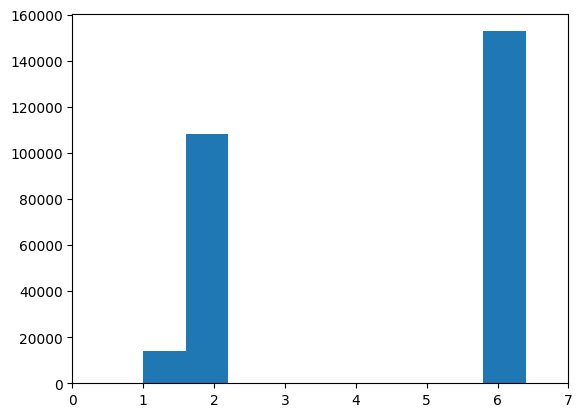

In [95]:
plt.hist(svm_pred2)
plt.xlim(0,7)
#plt.grid()
plt.show()

In [93]:
print(f"Accuracy: {accuracy_score(y_data2.ravel(), svm_image_default2.ravel())*100}")

Accuracy: 41.34242837653479


In [69]:
svm_pred2_proba = svm.predict_proba(X_test2, probability = True)

AttributeError: predict_proba is not available when  probability=False

In [101]:
gnb_pred2 = gnb.predict(X_scaled2)

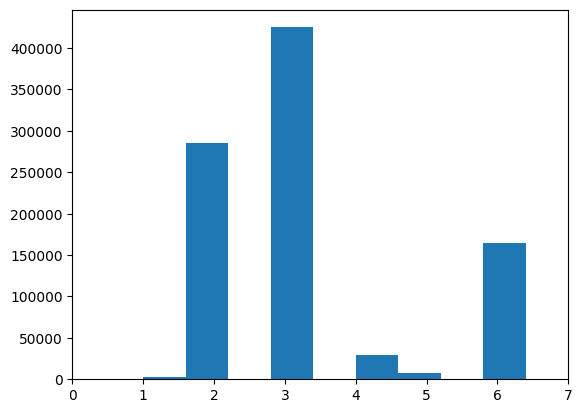

In [102]:
plt.hist(gnb_pred2)
plt.xlim(0,7)
plt.show()

In [103]:
print(f"Accuracy: {accuracy_score(y_data2.ravel(), gnb_pred2)*100}")

Accuracy: 36.98542974079127


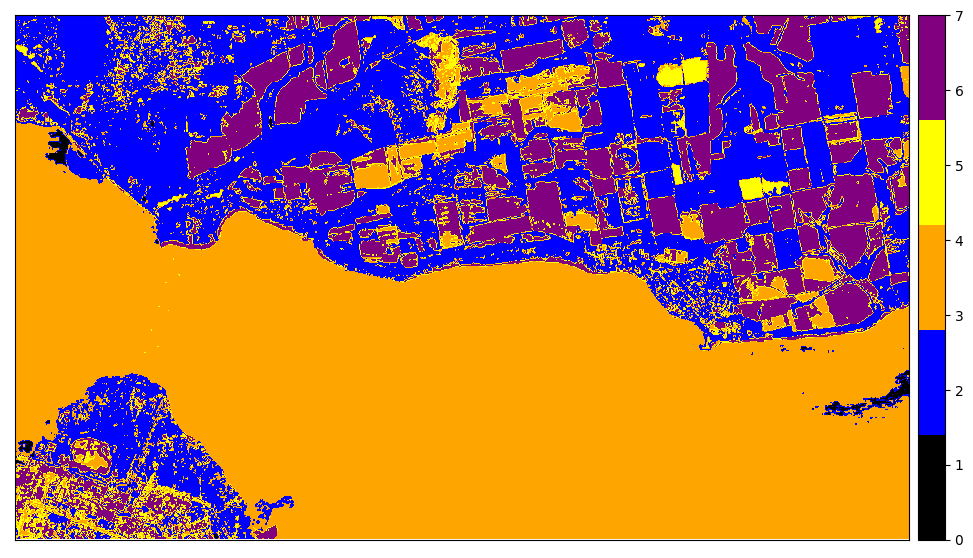

In [105]:
ep.plot_bands(gnb_pred2.reshape((733, 1250)),vmin=0,
              cmap=ListedColormap(['black', 'blue', 'orange', 'yellow', 'purple']))
plt.show()